# Product and Inventory Analysis

By Mark Mao, Shiqi Sun, Man Shi, Kangjing Shi, Jordan Grose

Dataset:  https://www.kaggle.com/flenderson/sales-analysis 

## General Summary
- Our goal is to come up with an Assortment Strategy as well as perform a general analysis of product performance for the SKUs in the "Active" inventory by analyzing the "Historical" dataset. We will also make references to a potential future analysis with the same dataset, namely, how we might structure a prediction model for the Active dataset to predict sales of Active SKUs. Our analysis is based off of two previously published notebooks analyzing the same dataset:
- Danai Avgerinou: https://www.kaggle.com/danavg/abc-analysis-of-active-inventory/notebook 
- mdneuzerling: https://www.kaggle.com/mdneuzerling/exploration-of-sales-data-with-some-modelling 
- Additionally, here is a html version of mdneuzerling's analysis: https://htmlpreview.github.io/?https://github.com/mdneuzerling/flenderson_sales/blob/master/exploration.html

## What is an Assortment Strategy and why is it important?
An Assortment Strategy is a method by which retailers prioritize and de-prioritize products on their shelves and in the inventory. There is no "one-size-fits-all" assortment strategy so we will be looking at a typical invetory classification method, "ABC Classification", as well as some correlations and summary statistics from the historical sales/inventory data to analyze current products in the inventory and possible assortments of products. Assortment Strategies and general product analysis are important because they give companies the power to sell more products at higher prices and incur fewer inventory costs.


## Data Preprocessing and Setup

We want to start off by establishing that we do not know what industry the dataset comes from or what the actual products are. However, we have enough data on SKU sales, quantities, marketing strategy and performance for each SKU for us to perform an analysis of the active inventory. 

In [2]:
%%bigquery
SELECT * FROM `ba775-team-3a-291914.groupproject.original`
LIMIT 5

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
0,61591,Historical,2837806,1,6,S,5,1,51676,76.97,1979,98,53.26,53.93
1,71183,Historical,619084,1,9,S,0,0,394651,105.00,1985,80,23.98,78.26
2,11377,Historical,613447,1,6,D,1,0,148692,86.75,1988,70,75.74,17.99
3,22742,Historical,534353,1,6,D,1,0,103833,58.00,1992,86,59.95,40.95
4,18090,Historical,613445,1,5,D,2,1,144601,38.00,1994,86,33.33,59.98


The dataset is comprised of 15 features for each SKU row, which corresponds to a distinct SKU. Below are some specifications and summary statistics about the data we would like call out:

- File_Type: We start by splitting the dataset into two groups based on the binary field File_Type. "Active" SKUs are the products that make up the current inventory. "Historical" SKUs represent previous products in older inventories. It is important to note that each SKU only appears once in each of the historical and active datasets. Meaning, when we split the data into two groups, we eliminate duplicates in each group. However, many of the SKUs in the active dataset, also appear in the historical dataset. This is important because it enables us to look at the historical sales performance for many of the active SKUs.
- SoldFlag & SoldCount: For the Historical dataset, we know which SKUs have been sold in the last 6 months and the quantities of those SKUs sold via the SoldFlag & SoldCount fields. The active dataset does not have any sales data, meaning these fields will be NULL for all SKUs in the active dataset. If the SKU has been sold in the last six months, SoldFlag = 1, and SoldCount will be the number of units sold within the last six months.
- Marketing Type: For each SKU, the dataset provides a "Marketing Type" with values "D" and "S". We do not know exactly what these values stand for, however, we can still analyze historical sales performance for each SKU by Marketing Type.
- Strength Factor: While we do not know how this number is generated, we can still analyze it's relationship with Historical SKU sales performance.
- PriceReg, LowUserPrice, LowNetPrice: SKU Price has proved to be tricky so far. There are currently three price fields in both Active and Historical datasets with little to no description of what each mean from the data provider: "PriceReg", "LowUserPrice", and "LowNetPrice". Additionally, many prices in the dataset are missing across all three price fields or have a price of "0". This can propose issues for us. As suggested by mdneuzerling's analysis, we will focus on analyzing LowUserPrice and PriceReg as they have fewer missing or "0" values. mdneuzerling amounts the missing or "0" price values to poor data collection.
- ItemCount: The quantity of each SKU in the respective inventory.
- New_Release_Flag & ReleaseNumber: SKUs that are on schedule to be released in the future will have New_Release_Flag = 1, and ReleaseNumber > 1.

Below are two summary queries for the Historical SKUs. We can see that there are 75,996 total distinct SKUs in the historical dataset, 12,996 that have been sold in the last six months and 63,000 have not been sold in the last six months. In combination with other variables, whether the SKU has been sold in the last six months will be our launching point for analysis of which SKUs are better performing from a sales perspective.

In [3]:
%%bigquery
SELECT COUNT(DISTINCT SKU_number) as Historical_SKUs, SoldFlag FROM `ba775-team-3a-291914.groupproject.master-historical`
Where SoldFlag = 1
Group by SoldFlag

,Historical_SKUs,SoldFlag
0,12996,1


In [4]:
%%bigquery
SELECT COUNT(DISTINCT SKU_number) as Historical_SKUs, SoldFlag FROM `ba775-team-3a-291914.groupproject.master-historical`
Where SoldFlag = 0
Group by SoldFlag

,Historical_SKUs,SoldFlag
0,63000,0


Similarly, below we can see the breakdown of the two possible Marketing Types for the Historical SKUs.

In [5]:
%%bigquery
SELECT COUNT(DISTINCT SKU_number) as Historical_SKUs, MarketingType FROM `ba775-team-3a-291914.groupproject.master-historical`
Where MarketingType = "D"
Group by MarketingType

,Historical_SKUs,MarketingType
0,35119,D


In [6]:
%%bigquery
SELECT COUNT(DISTINCT SKU_number) as Historical_SKUs, MarketingType FROM `ba775-team-3a-291914.groupproject.master-historical`
Where MarketingType = "S"
Group by MarketingType

,Historical_SKUs,MarketingType
0,40877,S


## Active Inventory Data with ABC Classification
Before we get into analysis of other variables let's first outline one option for our assortment strategy, ABC Inventory Analysis.

Now that we have partitioned our dataset into Active and Historical groups and have called out a few key variables in each group, let's further segment our Active inventory. ABC Inventory Analysis is a common method for segmenting a current inventory that takes into account the price and quantity for each SKU. There are number of ways that retailers harness this segmentation technique, but we will primarily use it to rank SKUs in the active inventory by their total value, or Additive_Cost:  AddCost = (LowUserPrice * ItemCount). Since we do not know of any existing warehousing or inventory costs, we are equating the SKU's total value to also be the SKU's additive cost, meaning the cost of each SKU stored in the inventory to the retailer is equal to the price of selling all units of each SKU at the specified price. In other words, the total value of each SKU is equal to the opportunity cost of not selling all units of each SKU and holding it in the inventory.

After we rank each SKU by total cost, we can create a running cumulitive cost of the active inventory and show each SKU as both a quantity and value percentage of the entire inventory quantity and value, respectively. Using the below rubric, we have assigned a class value of A, B or C to each SKU. In general, SKUs in the A class are more valueable (price * quantity), or have a higher opportunity cost to the retailer, whereas SKUs in the C class are less valuable, or costly, to the retailer. Typically an inventory will have fewer "high value" SKUs and many "low value" SKUs. The retailer should prioritize selling Class A SKUs to maintain a healthy inventory cost and make more money through high value sales.

- Below is a table that previews the Active dataset
- Table includes the new "Class" field that denotes which inventory cost class (A, B, or C) each SKU is within
- Below is the ideal structure for each cost class that generally follows Pareto's Law:

- A items - Captures roughly 20% of the items in the relevant inventory and accounts for roughly 70% of the inventory value
- B items - Captures roughly 30% of the items in the relevant inventory and accounts for roughly 25% of the inventory value
- C items - Captures roughly 50% of the items in the relevant inventory and accounts for roughly 5% of the inventory value


In [1]:
%%bigquery
SELECT * FROM `ba775-team-3a-291914.groupproject.active_ABC`
ORDER BY Class
LIMIT 5

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,AddCost,RunCumCost,TotSum,RunPerc,Class
0,124784,Active,2157997,NA,NA,S,1,0,17835.54750,17.00,2006,256,4.00,7.73,1024.00,21979829.32,58985115.47,0.372633,A
1,205268,Active,55424,NA,NA,D,5,1,27184.89250,89.95,2010,256,3.84,27.74,983.04,22876230.46,58985115.47,0.387831,A
2,176299,Active,612864,NA,NA,S,2,1,34363.66625,34.95,2003,256,4.00,10.94,1024.00,21976757.32,58985115.47,0.372581,A
3,127784,Active,1560157,NA,NA,S,0,0,52175.37875,9.99,2008,256,3.97,7.94,1016.32,22131878.45,58985115.47,0.375211,A
4,107440,Active,105640,NA,NA,S,0,0,244498.23130,12.00,1999,256,4.00,0.00,1024.00,21975733.32,58985115.47,0.372564,A


Below is a count summary of each class. The 30,374 SKUs in Class A should be prioritized from a selling perspective to maintain a healthy inventory cost and boost revenue form high value sales.

In [2]:
%%bigquery
SELECT Class, COUNT(class) as count FROM `ba775-team-3a-291914.groupproject.active_ABC`
GROUP BY Class

,Class,count
0,C,54626
1,A,30374
2,B,37921


## Data Analysis

Now we can start analyzing the data in both the Historical and Active datasets. Specifically we will be looking at how Price, Marketing Type, and New_Release_Flag affect the sale of the SKU (SoldFlag = 1) in the historical dataset.

Let's first start off by seeing a preview of the SKU data for both datasets, first Historical then Active:

In [4]:
%%bigquery
select * 
FROM `groupproject.master-historical`
limit 5


,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
0,19064,Historical,617754,0,0,D,1,0,284583,65.00,1935,43,82.34,47.48
1,70294,Historical,556147,0,0,S,7,1,70309,71.00,1945,47,26.95,48.47
2,9519,Historical,2339211,0,0,D,1,0,2322469,161.03,1950,33,0.00,87.24
3,12065,Historical,2421624,0,0,D,1,0,1005442,0.00,1950,22,0.00,63.99
4,8554,Historical,2421940,0,0,D,1,0,3417576,0.00,1952,17,55.29,54.53


In [5]:
%%bigquery
select * 
from `groupproject.master-active`
limit 5

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
0,153592,Active,294185,NA,NA,D,2,1,2.972561e+05,68.99,0,44,11.66,44.02
1,85289,Active,2299537,NA,NA,D,0,0,6.428200e+04,124.36,1900,14,81.57,119.32
2,85591,Active,704877,NA,NA,D,0,0,1.612739e+06,44.94,1900,29,4.00,44.94
3,86029,Active,1829136,NA,NA,D,0,0,8.694333e+06,101.33,1900,2,0.00,136.20
4,86101,Active,525033,NA,NA,D,0,0,1.034860e+06,627.99,1900,72,4.00,11.99


Average of each numerical feature in active set:

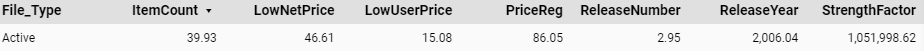

Average of each numerical feature in historical set

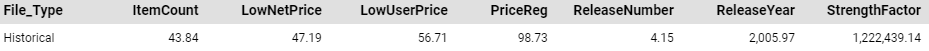

As we can see some features in the historical set have very different distritbutions then the active set, we want to investage more about those features.

We can see that the average of LowUserPrice differ significantly in two data sets. 

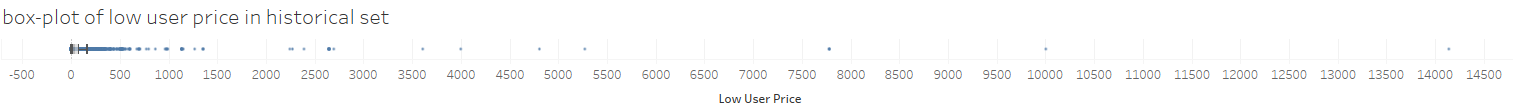

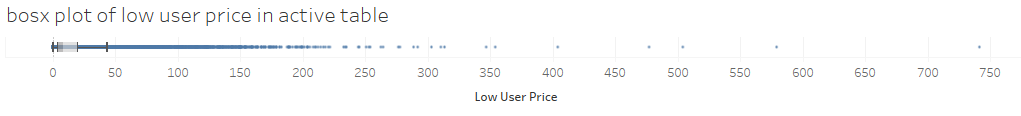

From the two box plots above, we find that such difference in LowUserPrice may be caused by a larger ratio of 0 and extreme values in the Historical set and the value in active set is generally much smaller.

This should be taken into consideration if we were to use LowUserPrice as a feature in prediction model.

## Difference between Historical data and Active data (Marketing_Type)
Now let's take a look at differences in MarketingType between the datasets. Below is a frequency chart for both historical and active datasets of MarketingType. There are two categories of how we market the product, D and S. Each type should be considered independently.
- For historical data, orders with MarketingType S are more frequent.
- For active data, SKUs with MarketingType D are more frequent.
- As we compared historical data and active data, we found historical data have more SKUs with MarketingType S, but active data have more MarketingType D. From that we can make two guesses: products with S MarketingType did not perform as well, so the company possibly stopped releasing those products. Another is that there are less SKUs with MarketingType S in the active inventory due to seasonality reasons. Since the active inventory is the inventory at the most recent snapshot in time, perhaps MarketingType S is less frequent at this current time due to seasonality reasons. Could "S" stand for "Seasonal Marketing"? We will explore this more later.


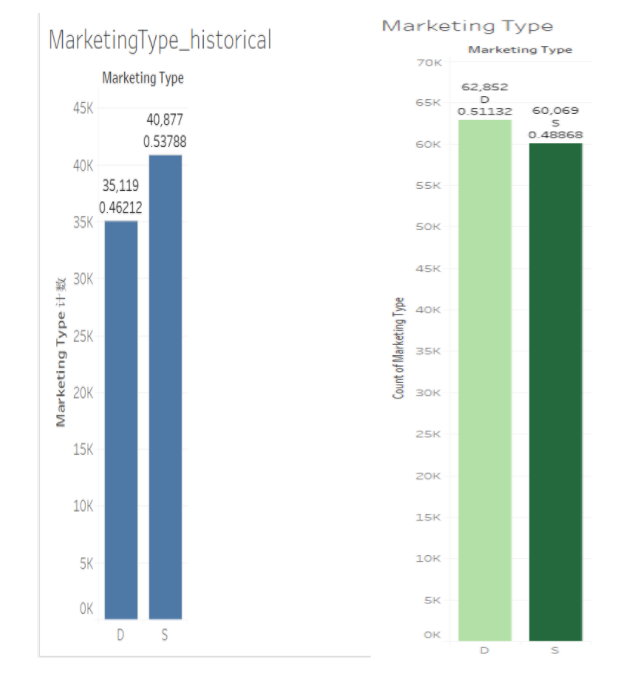

Next, let's investage how MarketingType influences the SoldFlag, SoldCount and other features in both Histoical and Active data-set. Below is the average of each feature under different Marketing Type in Historical set:

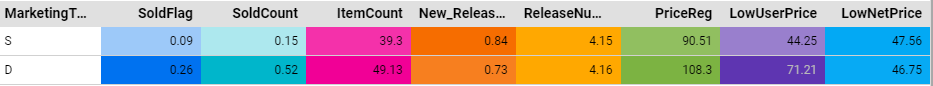

As we can see from above, the MarketingType D has much higher soldflag average, soldcount, Itemcount, and LowUserPrice average.
As the sold flag is a binary classification variable and the variable we want to predict in the future, we use that as additional label for this subgrouping:


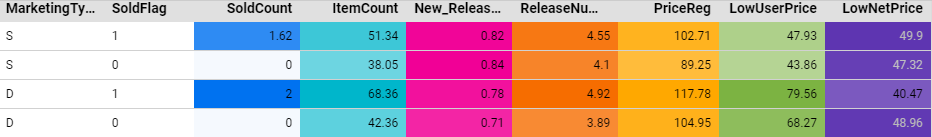

We can see most features are positivily correlated with SoldFlag under each MarketingType except the LowNetPrice in MarketingType D where soldflag is negtively correlated with the average of LowNetPrice. However, we take this with a grain of salt since we already established that LowNetPrice exhibits poor data integrity.

Now that we have an understanding of how MarketingType behaves within the Historical dataset, let's now explore the relationship between MarketingType and Sold Count, Sold Flag, New release Flag and Item Count.

Below is a breakdown of sold products and not sold products for MarketingType D and S.

In [1]:
%%bigquery
SELECT countif(SoldFlag = 1) as SoldFlag_1, countif(SoldFlag = 0) as SoldFlag_0, MarketingType 
FROM `ba775-team-3a-291914.groupproject.master-historical` 
group by MarketingType

,SoldFlag_1,SoldFlag_0,MarketingType
0,9154,25965,D
1,3842,37035,S


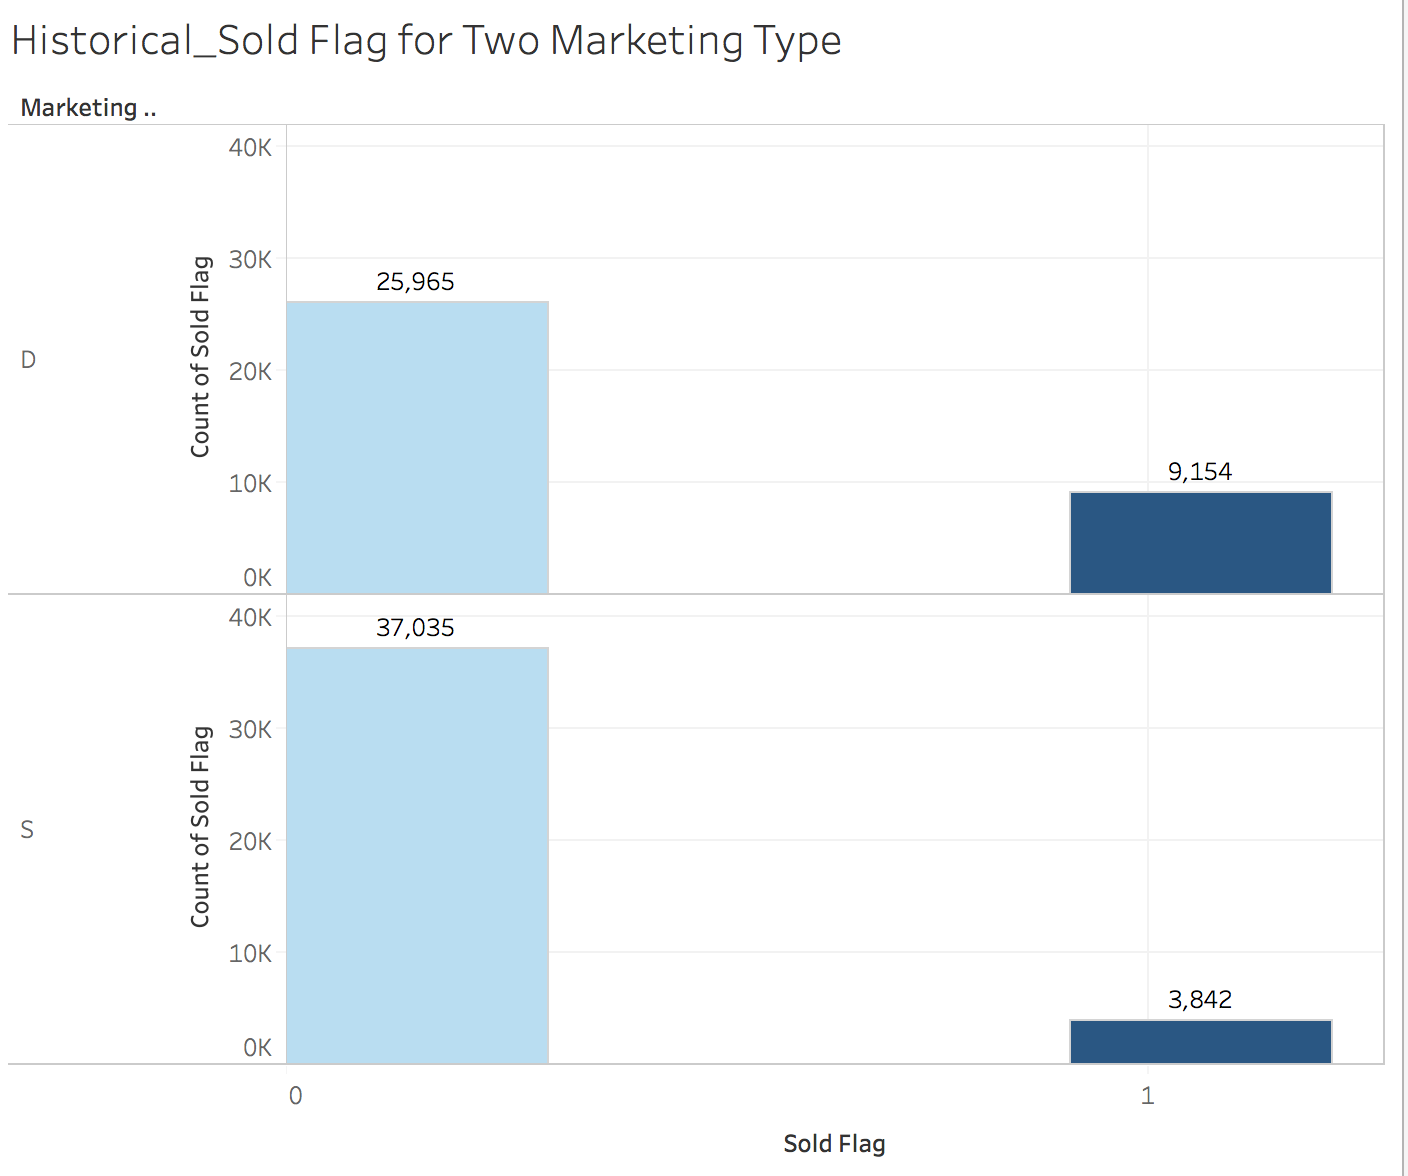

MarketingType D products had better sales performance than Type S in last 6 months. Again, we are unsure as to the specific differences between MarketingType D & S, however we suspect that SKUs with MarketingType D typically sell more often and should be prioritized. We would expect a future prediction model to predict more sales of products with MarketingType D.

Below is the average SoldCount, ItemCount and whether products have a future release for MarketingType D and S products.

In [13]:
%%bigquery
SELECT  MarketingType,  New_Release_Flag, avg(SoldCount) as avg_soldcount, avg(ItemCount) as avg_ItemCount 
FROM `ba775-team-3a-291914.groupproject.master-historical` 
group by MarketingType, New_Release_Flag

,MarketingType,New_Release_Flag,avg_soldcount,avg_ItemCount
0,D,0,0.440678,34.530826
1,S,1,0.146586,38.421384
2,S,0,0.181335,43.862822
3,D,1,0.549593,54.502122


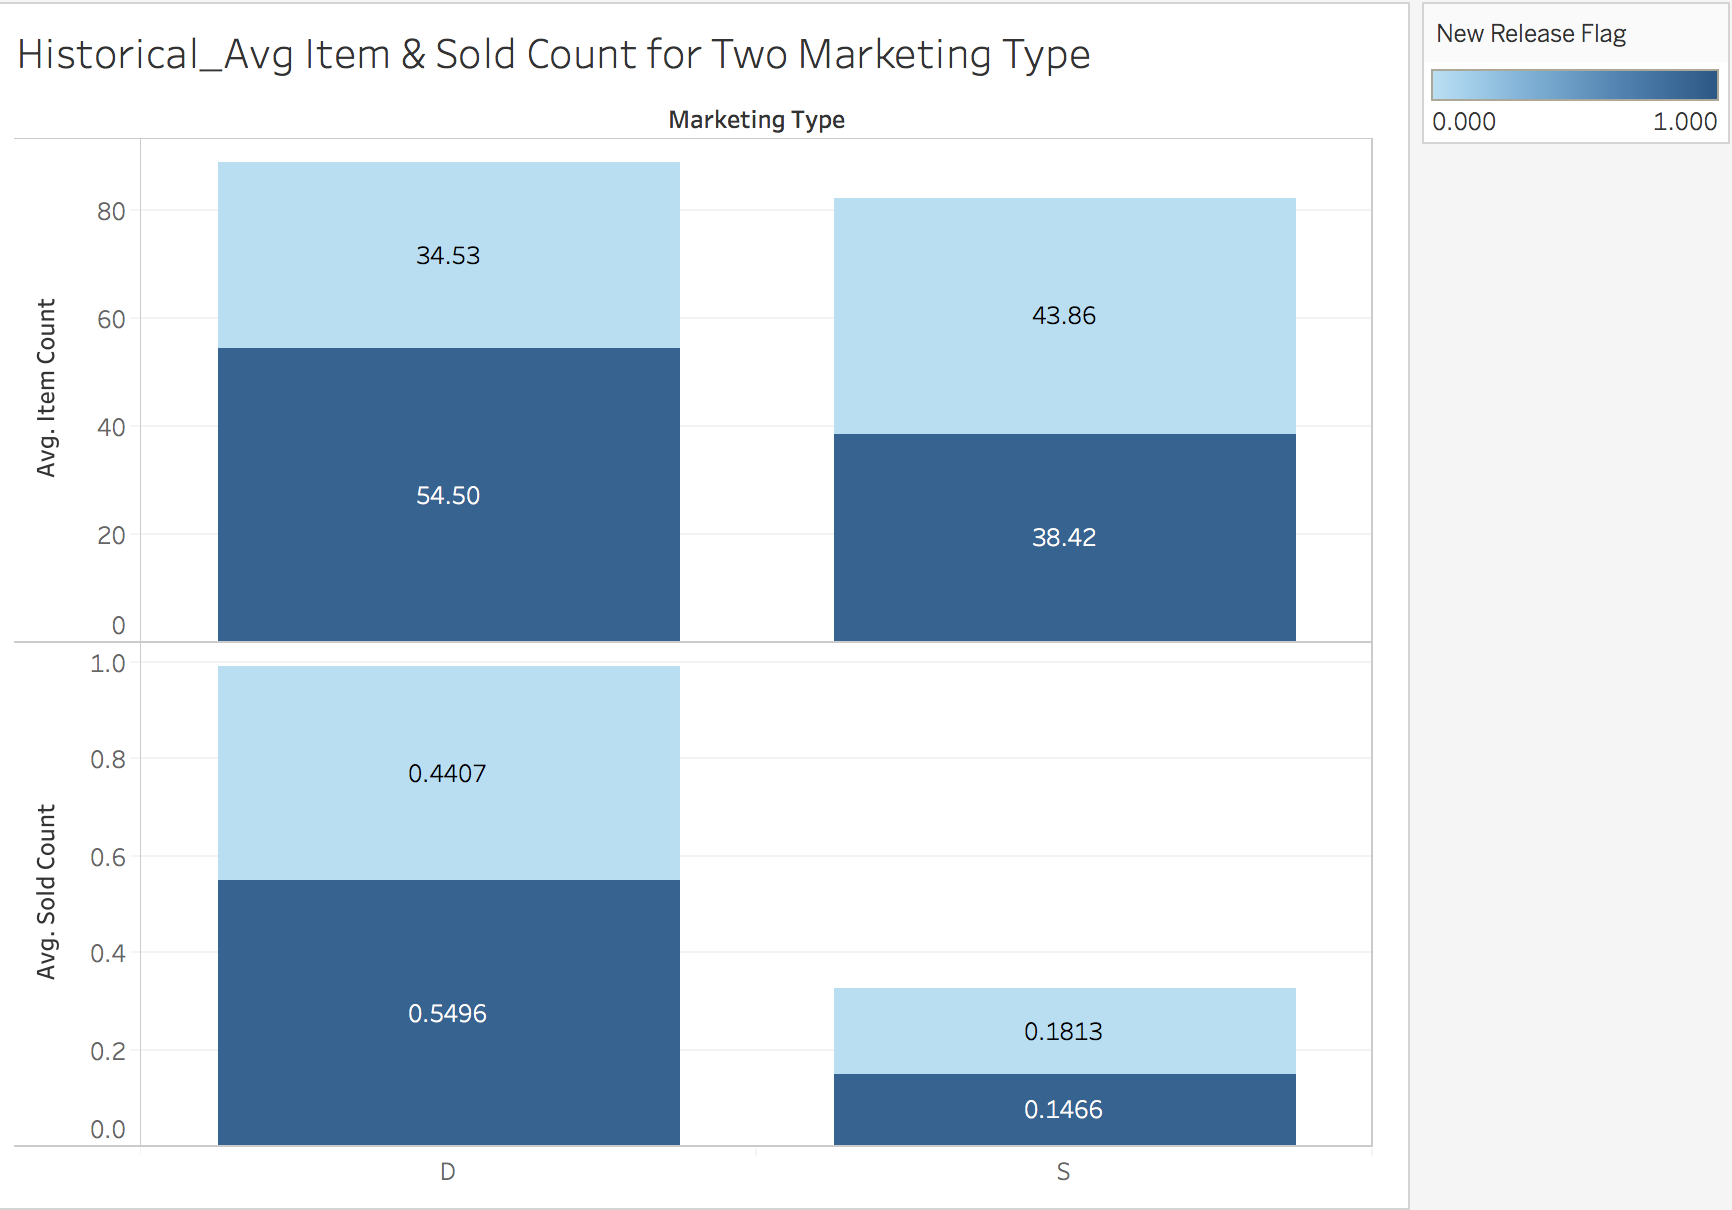

Type D products with New_Release_Flag = 1 or 0 show relatively better sales performance than type S products with New_Release_Flag = 1 or 0. This confirms our previous finding that type D products have a higher probability of selling in the future.

## New_Release_Flag
Let's take a closer look at products with and without future releases. To reiterate, any product that has had a future release (i.e., Release Number > 1). When ReleaseNumber is 0 and 1, New_Release_Flag will be 0.
- For historical dataset, the majority of data, which is 59,966 orders, has New_Release_Flag = 1, which means they will be released in the future. And 16,030 orders have New_Release_Flag = 0, that means they will not be released, or will only release 1 unit in the future.
- For active dataset, orders that have 0 and 1 released item have 28,697 and 26,436 SKUs, respectively, which forms the 55,133 orders which have 0 in the New_Release_Flag.
- It is difficult to explain the functionality of the New_Release_Flag. We don't know exactly why 0 and 1 values for ReleaseNumber have New_Release_Flag = 0. We guess it might be because 26436 out of 94227 released orders with only one future item will not play a significant role in inventory management due to low future quantities. Regarding the below two graphs, the Historical datasets have more shares of release items when the New_Release_Flag is 1. We would speculate that historical orders have better performance than active orders in general based on the definition of Sold Flag (1 = sold in past 6 mos. 0 = Not sold) and our definition of Release Number (count the number of items that are going to be released in the future).

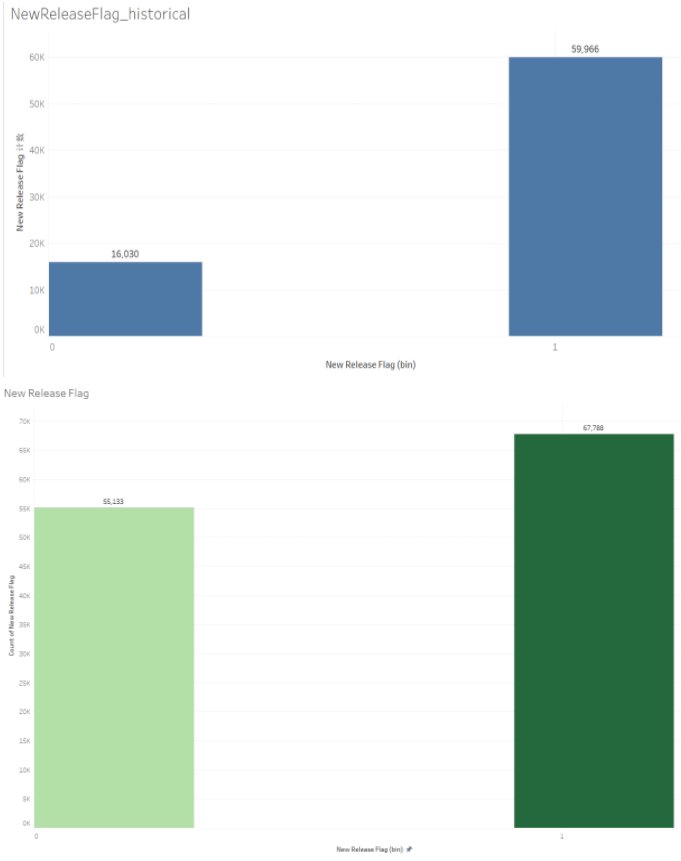

Let's look at how New_Release_Flag historically interacts with average SoldCount and ItemCount for sold products and not sold products.

In [6]:
%%bigquery
SELECT SoldFlag, New_Release_Flag, avg(SoldCount) as avg_SoldCount, avg(ItemCount) as avg_ItemCount
FROM `ba775-team-3a-291914.groupproject.master-historical` 
where (SoldFlag=0 and New_Release_Flag=1) or (SoldFlag=1 and New_Release_Flag=0)
group by SoldFlag, New_Release_Flag

,SoldFlag,New_Release_Flag,avg_SoldCount,avg_ItemCount
0,0,1,0.000000,40.953598
1,1,0,2.012401,52.110109


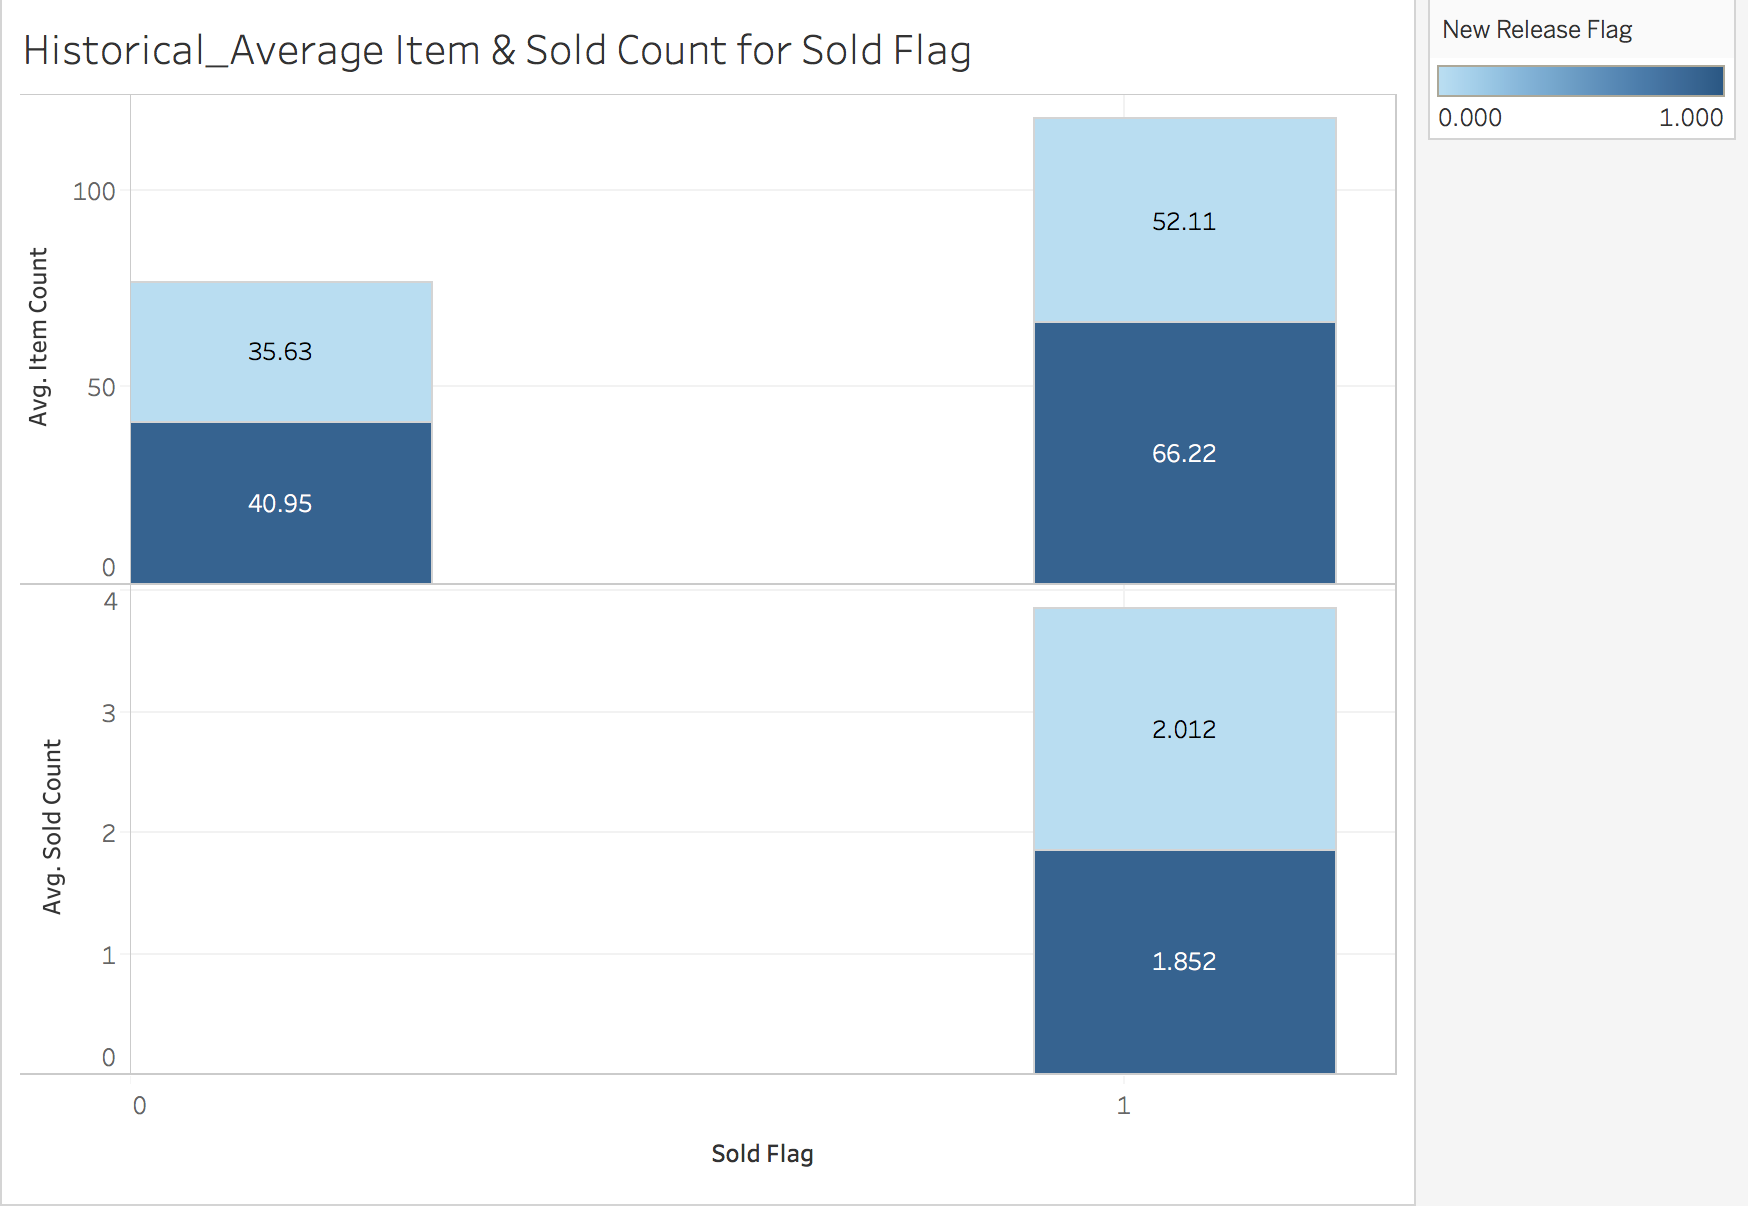

For the products that were not sold in last 6 months but would still release in the future (SoldFlag=0, New_Release_Flag=1) have a relatively larger number of average ItemCount (the number of items sitting in the inventory) of 40.95 units. This seems large when you consider that these items are not selling and in fact are just sitting in the inventory taking up space.

On the other hand, the average SoldCount for the products which would not be released in the future (New_Release_Flag=0) is relatively bigger and even exceeds those that would be released in the future (New_Release_Flag=1). Perhaps these products are selling historically, but the retailer knows that in the future they will not sell as well so they don't plan on releasing them again. Hint: perhaps this has to do with seasonality again?

In the historical data, some products where SoldFlag = 0 still have New_Release_Flag = 1 and ReleaseNumber is not 0. From our definition, we know that SoldFlag = 0 when the item has not been sold in past 6 months, and when New_Release_Flag = 1, products will be release in the future. Because those products have not been sold in the past 6 month, but will be sold in the future, we believe that the company may still plan on selling these specific products in the future due to seasonal reasons. For example, these items sell more over the Christmas period, like Winter jackets vs. swimwear.

In [1]:
%%bigquery
SELECT SKU_number, SoldFlag, ReleaseNumber, New_Release_Flag FROM `ba775-team-3a-291914.groupproject.master-historical`
WHERE SoldFlag = 0 AND New_Release_Flag = 1 
ORDER BY SKU_number
LIMIT 5

,SKU_number,SoldFlag,ReleaseNumber,New_Release_Flag
0,50001,0,8,1
1,50002,0,9,1
2,50003,0,10,1
3,50004,0,6,1
4,50005,0,7,1


## Price

Finally, let's look at how prices vary over both the Historical and Active datasets. As mentioned above, we will follow mdneuzerling's advice and primarily analyze PriceReg and LowUserPrice.

Below is a frequency distribution for PriceReg and LowUserPrice in both the Active and Historical Datasets. Below are our findings:
- PriceReg: Range(0,3986.31)
- LowUserPrice: Range(0,14140.21)
- Because there is no official explanation of PriceReg and LowUserPrice, we presume PriceReg stands for regular price. And, LowUserPrice represents the lowest price paid by the user (or customer).

    - PriceReg
        - For the historical dataset, we found the majority items are within 300 units, presumably US dollars.
        - For the active dataset, we find most orders fall in 10 to 110. 
    - LowUserPrice
        - For historical data, 9,101 items have low user price = 0, which seems incorrect. We speculate those orders might have been disposed in the inventory which means there are no more customers willing to pay for them. 
        - For active dataset, it is obvious to observe that a significant amount of share when Low User price is 4 dollars. Then, it goes down with fewer orders.
        
In the historical dataset, we found Historical Orders on average have higher PriceReg per item than Active items. Also, there are a significant amount of orders with low user price = 0 in the historical dataset. From our definition, we know PriceReg represents for regular price and low user price represents the lowest price paid by the user. We speculate Historical Orders might have higher volatility in supply and demand of the market. When the demand is higher than supply in the market, low user price tends to be higher as the graph shows which the lowest price paid by the customer is evenly distributed if we ignore when the low user price = 0. When the supply is higher, historical data has 9101 orders with 0 low user price. No more customers are willing to buy at this time. In summary, we believe historical orders sell more seasonal products due to festivals and climate. And, active orders have more household products.


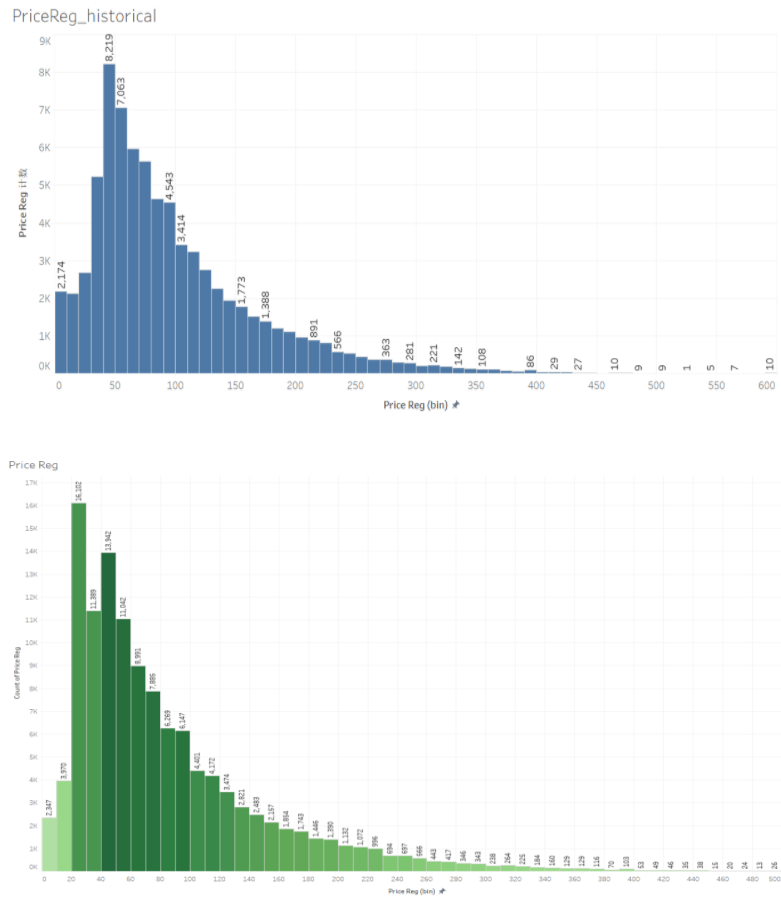
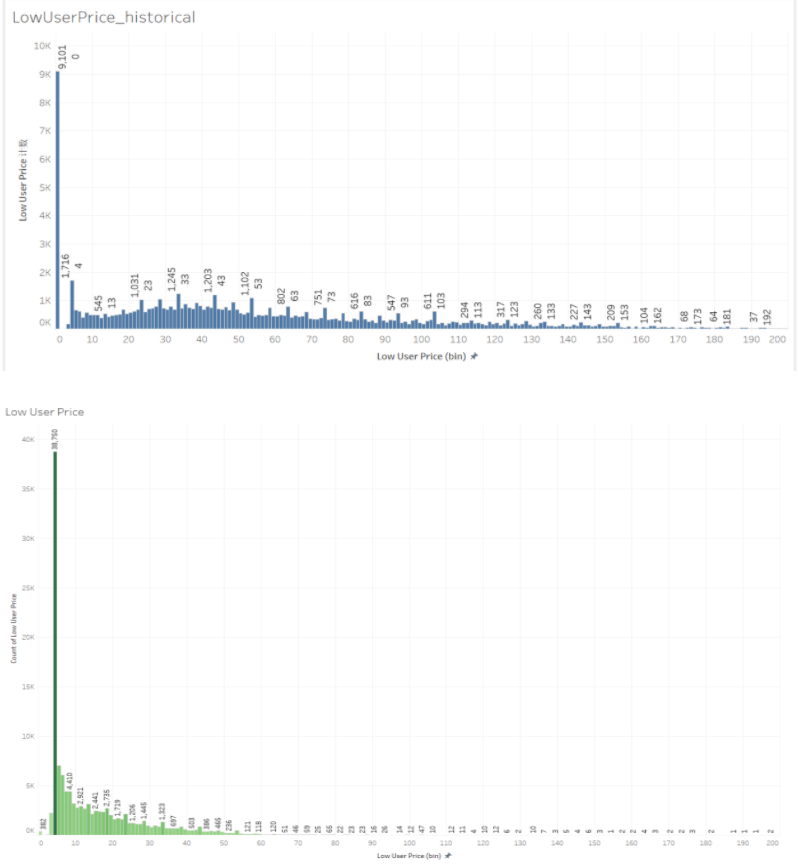

Let's next look at how Price interacts with SoldFlag in the Historical dataset to better understand the predictability of selling SKUs based on unit price.

Below are the three different average prices for sold products and not sold products in the Historical dataset.

In [22]:
%%bigquery
SELECT SoldFlag, avg(PriceReg) as avg_PriceReg, avg(LowUserPrice) as avg_LowUserPrice, avg(LowNetPrice) as avg_LowNetPrice
FROM `ba775-team-3a-291914.groupproject.master-historical` 
group by SoldFlag

,SoldFlag,avg_PriceReg,avg_LowUserPrice,avg_LowNetPrice
0,0,95.720003,53.923817,47.995921
1,1,113.324873,70.207255,43.260726


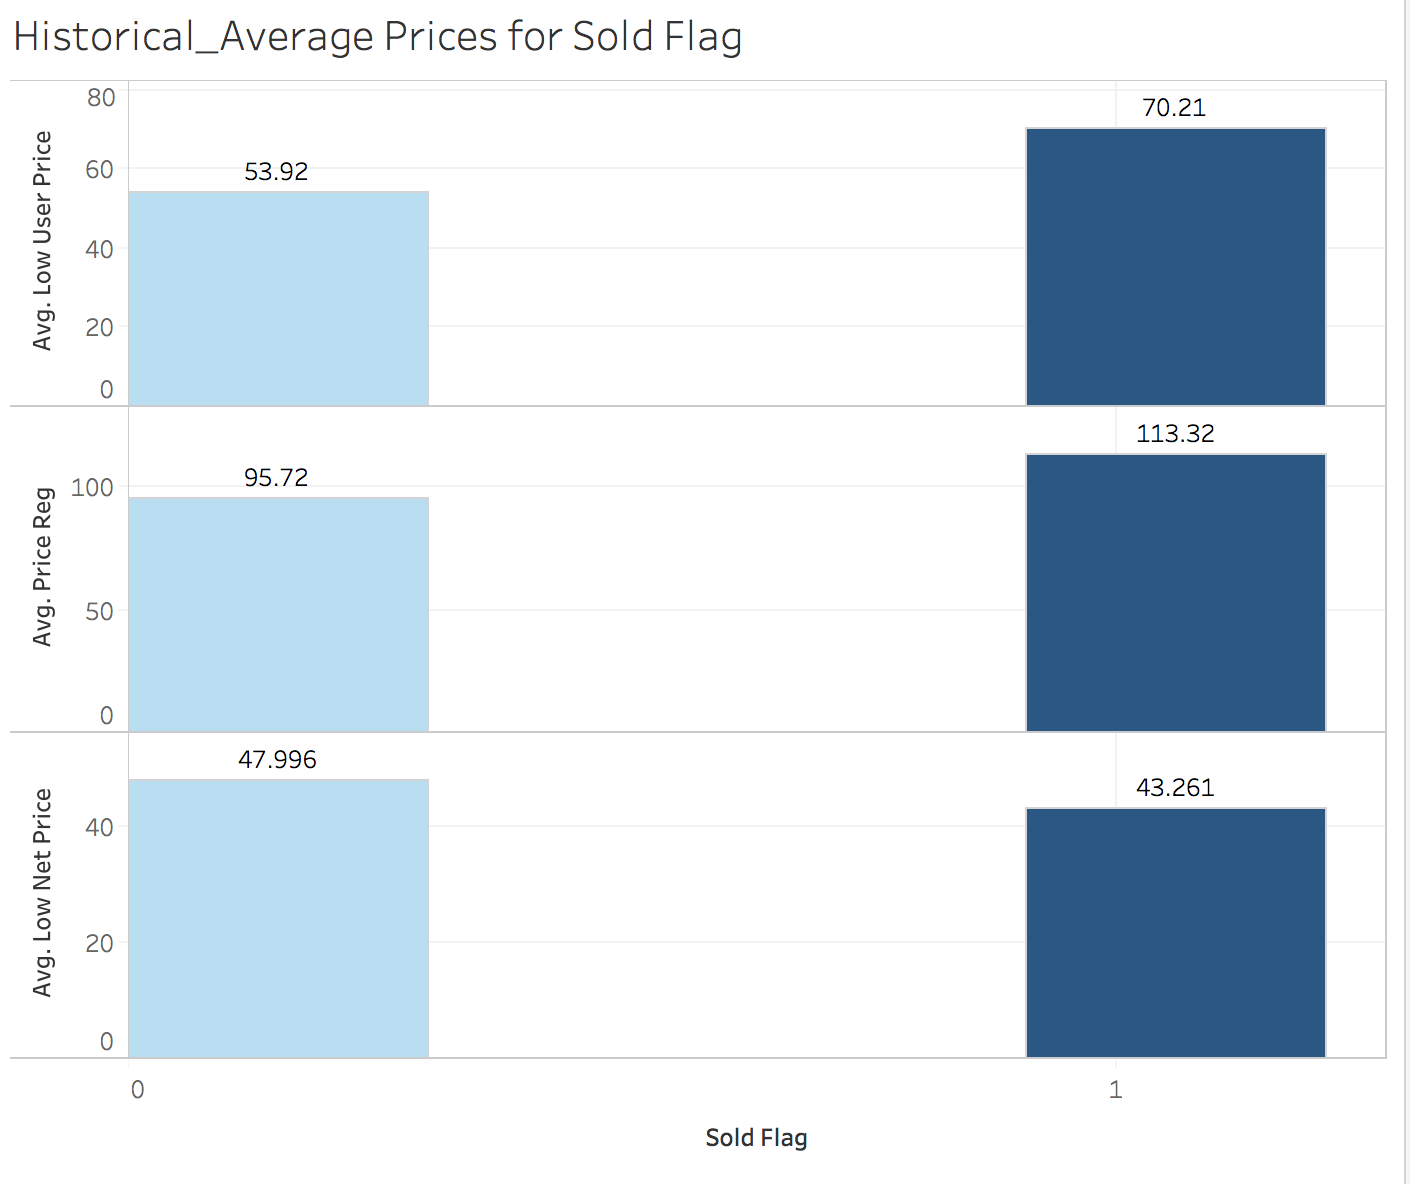
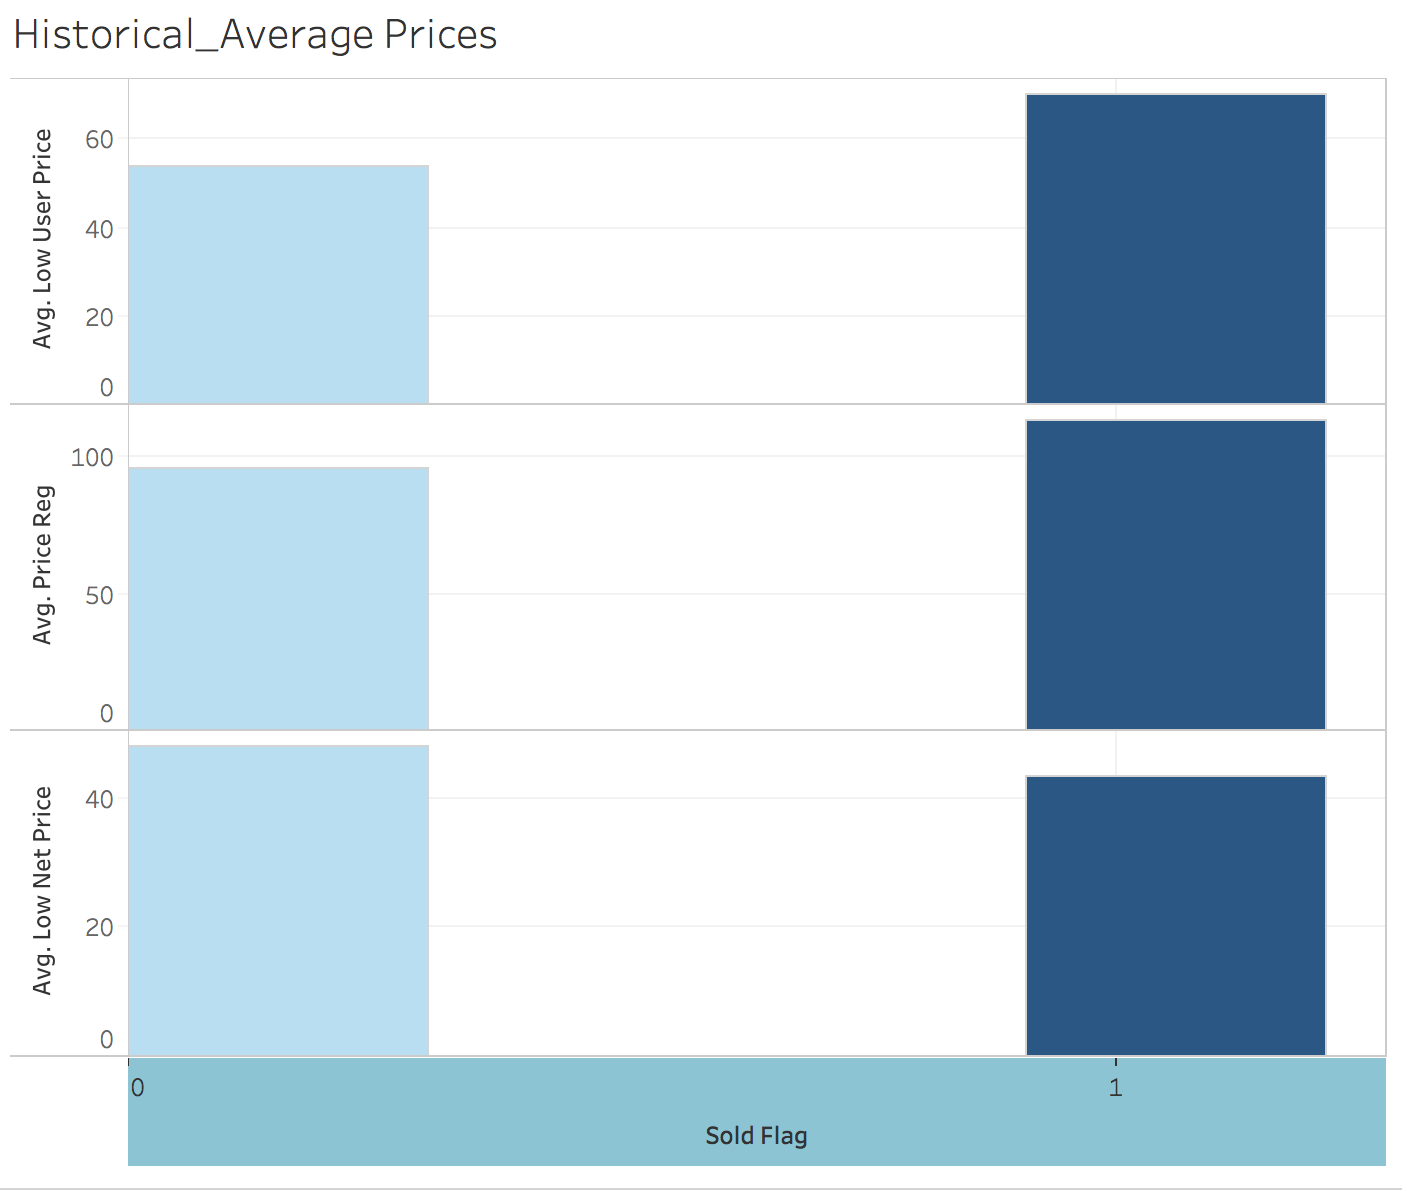

Again focusing on PriceReg and LowUserPrice, average PriceReg and LowUserPrice are higher for the products that were sold in last 6 months; but for products not sold in the last 6 months, the two average prices are lower. Only the average LowNetPrice is lower for sold products than not sold products, but we know from studying previous notebooks that LowNetPrice is not a reliable feature due to poor data collection and missing values. Regarding the higher PriceReg and LowUserPrice for items sold in the last six months, it seems contradictory to a typical retail business that a higher price would lead to more sales of a given product. Typically, we would expect a higher average price to result in less demand, or, fewer sales.

## Concluding Analysis Summary

Although we still do not know positively what industry and products we are analyzing with this dataset, we can still conclude a few points from our analysis. Below are our conclusions from the above analysis:

1. MarketingType D, historically has a higher probability of sale for both stagnant products and products with a planned future release.
2. Items with planned future releases exist in the Active inventory despite historically not selling in the last six months.
3. The two above points imply that a seasonality factor is in play here. Typically, we would not expect items to be stored in the active inventory unless they have a history of selling, otherwise why would the retailer take up the space in the inventory to store products that won't sell in the future? The answer is likely due to seasonality. Since we are looking at the active inventory as a snapshot in time, we don't know the time of year or industry of the sales data, and the historical sales data only goes back 6 months, we can guess that the retailer might choose to hold these items for a future release during the appropriate season.
4. While we found some conflicting correlations with SoldFlag across the three price variables, in general, we found that for PriceReg and LowUserPrice, higher priced SKUs historically see more sales in the last six months.
5. ABC Analysis of the active inventory shows us Class A SKUs that should be prioritized for future releases and sales. In other words, we would recommend to the retailer that setting higher average prices for SKUs in Class A during the right season would lead to higher sales and better inventory management.

## What do these five points suggest?



The most shocking piece of information we gathered from our analysis is that SKUs with higher price tend to sell more. Since we know the company has an inventory, we can safely assume that they are likely a storefront or retail-based company. Within retail, we typically see luxury goods as having this reverse price/demand relationship; higher price implies higher quality which, with the right buyers, can lead to higher sales. This, in combination with what we know about seasonality affecting whether the company plans to hold or release an item in the Active inventory, gives us a clue that the company might be in the luxury apparel industry. High quality, luxury clothes tend to be more expensive and sell at different times of the year depending on the season and the type of clothing. With this in mind, we can also make a guess as to the meaning behind different marketing types, D and S. Since we already found that SKUs with MarketingType D have more historical sales in the last six months than those with MarketingType S, perhaps the MarketingType denotes how different products are marketed throughout the year. We exptect that MarketingType D stands for "Daily Marketing", and MarketingType S stands for "Seasonal Marketing." This makes sense because we would expect products that are marketed daily to have higher sold counts than seasonal marketed products, depending on the time of the year. We also discovered above that the item count in the inventory for SKUs with seasonal marketing are higher than SKUs with daily marketing and have plans for future release. This means that seasonal products are stored in the inventory until they are planned to be released while daily marketed products are sold year round.

Our final recommendation to the company would be as follows:

1. Prioritize selling products in the Class A category to boost revenue per sale and maintain healthy inventory costs. As explored above, Class A products are typically more expensive. Now that we know luxury products tend to sell more at higher prices, prioritizing Class A products as a strategy is in line with an SKU assortment strategy that boosts sales performance.
2. Within Class A products, consistently market year-round products and plan for future release of those products via marketing type D.
3. Within Class A products, plan for timely releases of seasonal products and plan for appropriate future releases given the right season via marketing type S.

## Future Analysis: Predictions
As stated above, a future analysis to be considered might be a prediction model that predicts the probability of sale for SKUs in the Active inventory, based on historical data of those SKUs, namely, price, marketing type, and future release plan. One idea we came up with as a potential future project is attempting to predict the probability of sale ( P(sold_flag = 1) ) for each SKU in the active inventory, based off regression findings within the historical dataset. Once the expected probability of sale for each SKU is defined, we could combine those findings with our findings above to come up with a seasonal assortment strategy based off historical seasonal performance and likelihood of sale in the future. Given the integrity of the current dataset, missing values and variety of unkonwns, we would ideally require some additional data to generate the most accurate probability of sale. Here are some examples of potentially helpful additional data:

- Specific sale volumes (SoldCount) of SKUs by specified month to get an understanding of seasonal sales velocity
- Age a gender of customers to give more insight into future customer targeting
- Payment method for each sale can help us indicate potential social-economic status for customers and how that might influence a sale
- Platform on which the item is sold (amazon, physical storefront, online website, third party retailer) can give us insight into how products are sold and how various platforms perform across seasons.


## Extra: Machine Learning Models in different platform


As this project is mainly about exploring and describing, we only add a little portion of our machine learining model to provide a sense of how understand data  will benifit feature engineriing and machine learning model. 

we conduct a BQML logistic regression model in BigQuery as our base line-model with all features

In [3]:
%%bigquery
CREATE OR REPLACE MODEL `groupproject.classification_model`
OPTIONS
  (model_type='logistic_reg', labels = ['SoldFlag']) AS

WITH all_visitor_stats AS (
SELECT
  SKU_number,
  SoldFlag as will_SoldFlag
  FROM `groupproject.historical_ABC`
  GROUP BY SKU_number,SoldFlag
)


SELECT * EXCEPT(unique_session_id) FROM (

  SELECT
      SKU_number AS unique_session_id,

      # labels
     SoldFlag,

      #features
      ReleaseNumber,
      New_Release_Flag,
      StrengthFactor,
      PriceReg,
      ItemCount,
      ReleaseYear,
      LowUserPrice,
      LowNetPrice,
      TotalSum,
      MarketingType


  FROM `groupproject.historical_ABC`


  GROUP BY
  unique_session_id,
  SoldFlag,
        ReleaseNumber,
      New_Release_Flag,
      StrengthFactor,
      PriceReg,
      ItemCount,
      ReleaseYear,
      LowUserPrice,
      LowNetPrice,
      TotalSum,
      MarketingType
);

""


Then we run an Roc-accuracy analysis based on the model above:

In [2]:
%%bigquery
SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'decent'
    WHEN roc_auc > .6 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL groupproject.classification_model,  (

WITH all_visitor_stats AS (
SELECT
  SKU_number,
  SoldFlag as will_SoldFlag
  FROM `groupproject.historical_ABC`
  GROUP BY SKU_number,SoldFlag
)


SELECT * EXCEPT(unique_session_id) FROM (

  SELECT
      SKU_number AS unique_session_id,

      # labels
      SoldFlag,

      #feartures
      ReleaseNumber,
      New_Release_Flag,
      StrengthFactor,
      PriceReg,
      ItemCount,
      ReleaseYear,
      LowUserPrice,
      LowNetPrice,
      TotalSum,
      MarketingType


  FROM `groupproject.historical_ABC`


  GROUP BY
  unique_session_id,
  SoldFlag,
        ReleaseNumber,
      New_Release_Flag,
      StrengthFactor,
      PriceReg,
      ItemCount,
      ReleaseYear,
      LowUserPrice,
      LowNetPrice,
      TotalSum,
      MarketingType
)
));

,roc_auc,model_quality
0,0.74627,decent


In addition to that we did Random Forest model in R and Python environment

### Random Forest:
- R: with default setting and eliminate several low correlated features
- Python: with hyperparamenter tunning by Random search and serveral feature engineerings

### Deep Learning:
- Python: under tensorflow environment with serveral feature engineering 
        

## Result:
As deep learning shows the lowest perfromance in Roc-accuracy among all three models, we exculde that from the report. 

The Radnom Forest in R yields highest Roc-accuracy (0.8271) with clear overfitting issue, which make the model's scalability questionable. 

Similar issue is also shown in Random Forest model in Python. And the overfitting is clearly reduced by ptimizing hyperparameter setting from Hyperparameter tunning but it only yield a Roc-accuracy of 0.76

For further detail: visit the following github link:

https://github.com/mao289765/BA-775-team3a-project

## Link to our Dashboard
https://public.tableau.com/profile/tianzheng.mao#!/vizhome/ProductandInverntoryAnalysis/Dashboard12?publish=yes

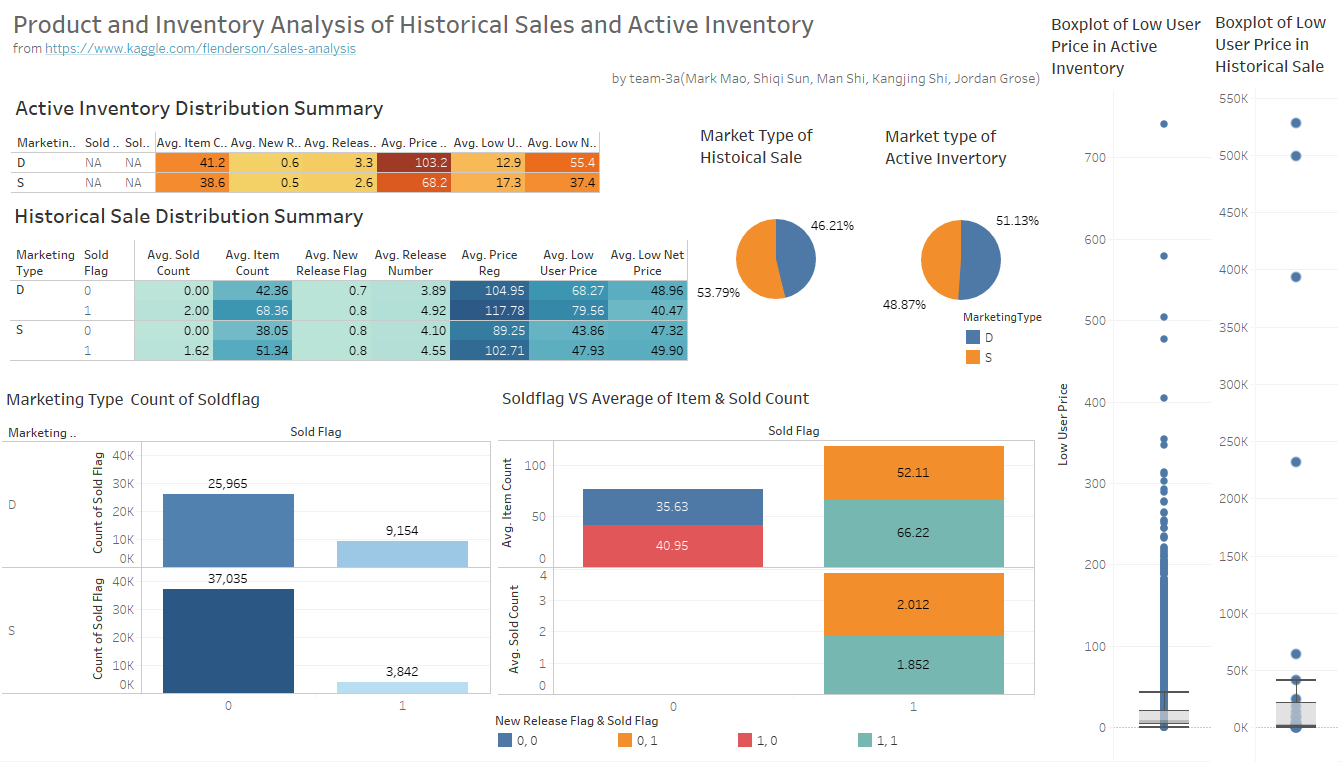